# Develop Regression Models for Soil Properties Estimation

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

### Load data

In [3]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data.csv')
tb_data_path = os.path.join(DATA_DIR, 'TB_blue_data.csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

### Data pre-processing

In [4]:
assign_num_list = {'topsoil layer': 0,
                      'weathered rock': 1,
                      'hard rock': 2,
                      'soft rock': 3,
                      'weathered soil': 4,
                      'colluvial layer': 5,
                      'moderate rock': 6,
                      'sedimentary layer': 7,
                      'reclaimed layer': 8}

In [5]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X','Y','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalized_X_train_ntb = normalizer.fit_transform(X_train_ntb)
normalized_X_train_tb = normalizer.fit_transform(X_train_tb)

# Deterministic Models

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

###  ANN

In [49]:
def create_model(dim):
    model = Sequential([
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    
    model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=0.001))
    
    return model

In [59]:
def get_checkpoint_best_only():
    current_dir = os.getcwd()
    checkpoint_path = current_dir + "/checkpoints_best_only/checkpoint"
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = "epoch",
                                save_weights_only = True,
                                monitor = "mean_squared_error",
                                save_best_ony = True,
                                verbose = 1)
    return checkpoint

In [60]:
def get_early_stopping():
    early_stopping = EarlyStopping(monitor = "loss", mode ="min", patience = 3)
    return early_stopping 
    

In [61]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [62]:
callbacks = [checkpoint_best_only, early_stopping]

In [63]:
model = create_model(dim = 3)

In [64]:
%%time
hist = model.fit(normalized_X_train_ntb, y_train_ntb, 
                  epochs = 100, verbose=1,
                batch_size=10,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 26.2937

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only/checkpoint
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 23.1008

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only/checkpoint
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 20.6949

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only/checkpoint
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 21.0705

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only/checkpoint
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 23.8494

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only/checkpoint
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - los

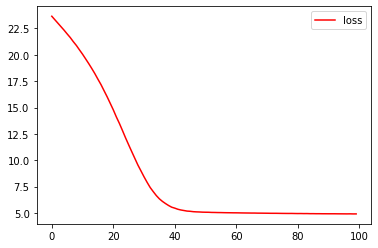

In [65]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.legend()
plt.show()


# Probabilistic models